# 프로젝트 : Segmentation map으로 도로 이미지 만들기

다음의 데이터셋을 이용해 Pix2Pix를 학습시킨다. (1000개의 학습용 이미지 및 5개의 평가 이미지를 포함)

데이터셋 : [cityscapes.zip](https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip)

프로젝트를 수행을 위한 참고용 튜토리얼

- [Tensorflow Pix2Pix Tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko)

### 프로젝트 수행
---
프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

1. 데이터에 한 가지 이상의 **augmentation 방법을 적용**하여 학습해주세요.
(어떠한 방법을 사용했는지 적어주세요.)

2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 **U-Net Generator**를 사용해주세요.

3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.

4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 **스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화**해 주세요.

5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 **중간 손실 값에 대한 로그**를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

## 목차
[프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기](#프로젝트-1-:-직접-고른-이미지로-SRGAN-실험하기)   
[프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기](#프로젝트-2-:-SRGAN을-이용해-고해상도-gif-생성하기)  
[Rubric](#Rubric)  
[회고](#회고)

## 1. Library Import

In [1]:
import tensorflow as tf
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses, optimizers

import os
import cv2
import time
import numpy as np

from matplotlib import pyplot as plt
from IPython import display

# !pip install -q -U tensorboard

## 2. 데이터셋 Load

In [2]:
path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/'

train_path = path + 'train/'
val_path = path + 'val/'

print("number of train examples :", len(os.listdir(train_path)))
print("number of validation examples :", len(os.listdir(val_path)))

number of train examples : 1000
number of validation examples : 5


#### 학습용 데이터셋에서 임의로 6장을 선택하여 시각화

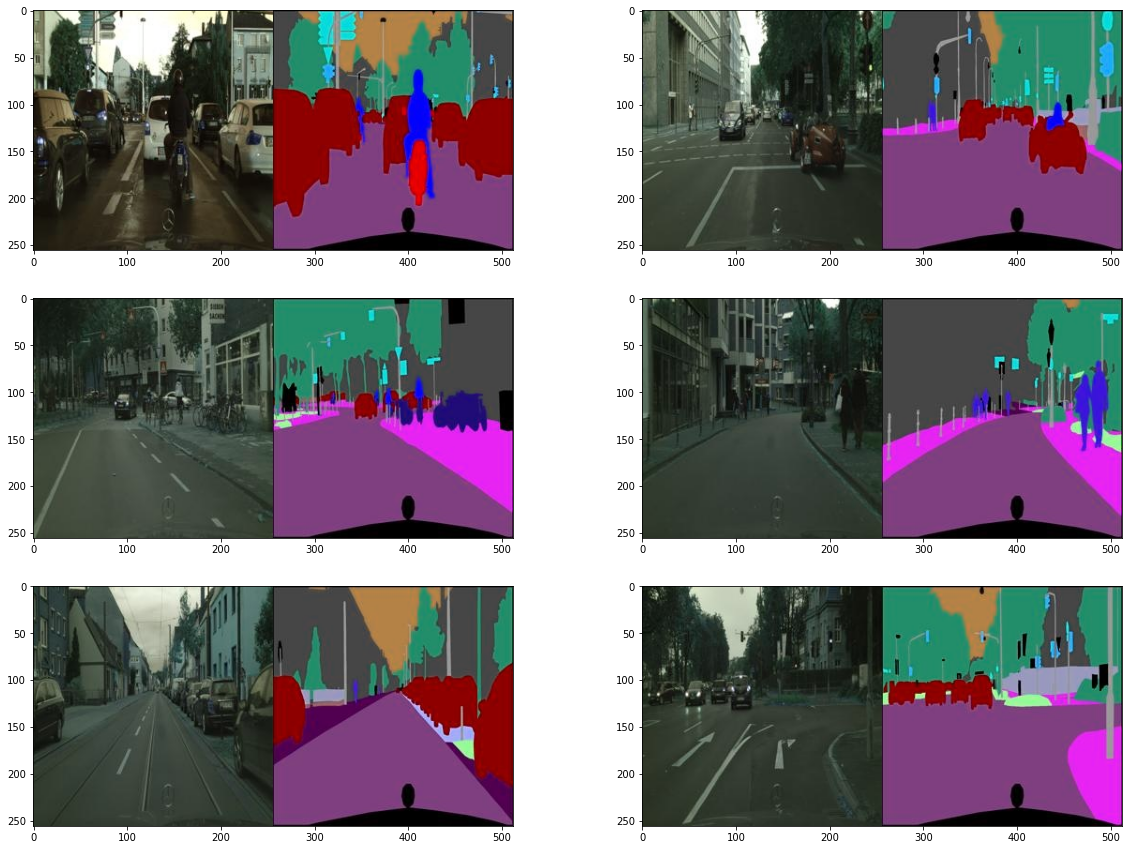

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_path + os.listdir(train_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
f = train_path + os.listdir(train_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


#### 모델 학습에 사용할 데이터를 2개 이미지로 분할

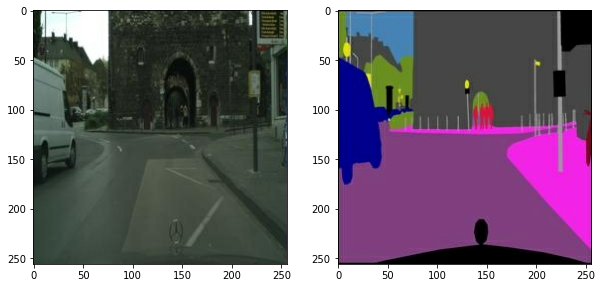

In [5]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = train_path + os.listdir(train_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## 3. Data Augmentation

In [6]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]

#### 위와 같이 구성한 함수를 데이터에 적용해 시각화

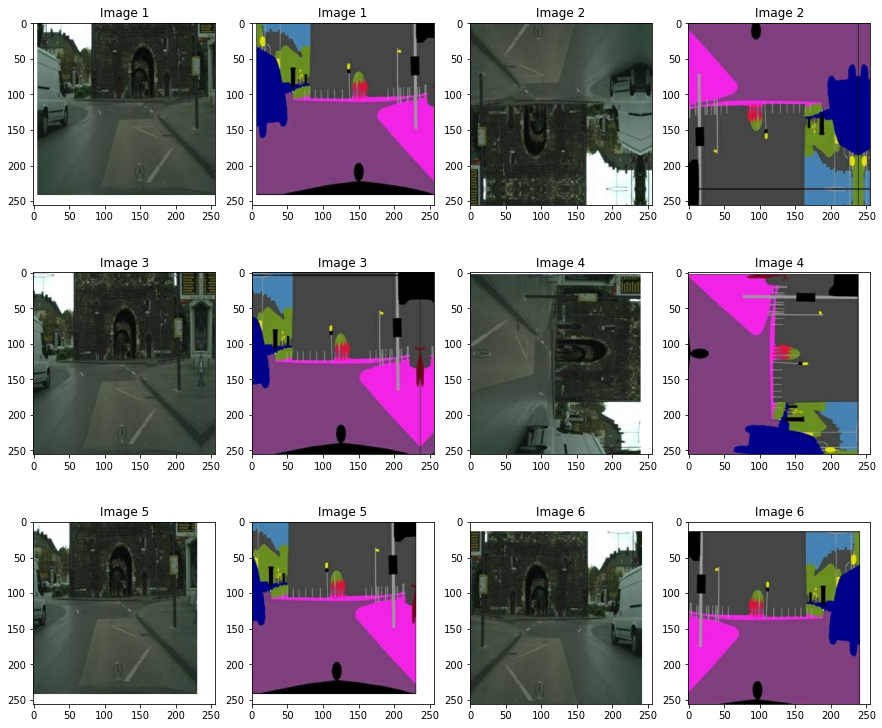

In [7]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

#### 학습 데이터에 잘 적용되었는지 하나의 이미지만 시각화하여 확인

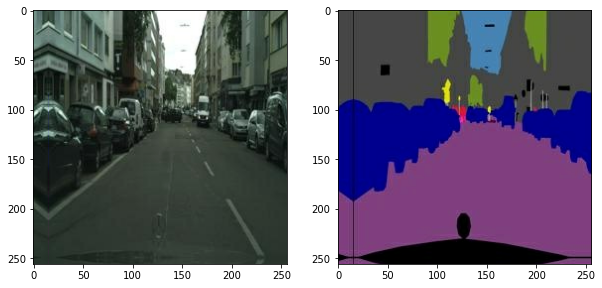

In [8]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(train_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 4. Generator 구성하기

In [9]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [10]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [11]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## 5. Discriminator 구성하기

In [12]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [13]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [14]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

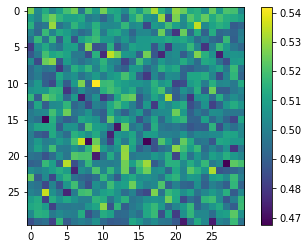

In [15]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 6. 학습 및 테스트하기

#### Generator 및 Discriminator의 손실 계산 및 optimizer 설정

In [16]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

#### 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트

In [17]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

#### 20 epoch로 학습을 진행

In [ ]:
EPOCHS = 20

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0263                     
L1_loss:0.2982                     
Discriminator_loss:1.0894

EPOCH[1] - STEP[20]                     
Generator_loss:1.1467                     
L1_loss:0.3089                     
Discriminator_loss:1.0294

EPOCH[1] - STEP[30]                     
Generator_loss:1.0121                     
L1_loss:0.3289                     
Discriminator_loss:1.4010

EPOCH[1] - STEP[40]                     
Generator_loss:1.4863                     
L1_loss:0.2998                     
Discriminator_loss:0.7503

EPOCH[1] - STEP[50]                     
Generator_loss:1.6754                     
L1_loss:0.2137                     
Discriminator_loss:0.9526

EPOCH[1] - STEP[60]                     
Generator_loss:1.8721                     
L1_loss:0.2194                     
Discriminator_loss:0.5961

EPOCH[1] - STEP[70]                     
Generator_loss:1.8075                     
L1_loss:0.2591                    

In [ ]:
test_ind = 1

for i in range(len(os.listdir(val_path))):
    f = val_data_path + os.listdir(val_path)[i]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))

## Rubric

||**평가 문항**|**상세 기준**|
|:--------|:--------|:--------|
|**1**|pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.|데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.|
|**2**|pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.|U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.|
|**3**|학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.|10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.|

## 회고
SRGAN을 이용해 저화질 이미지를 고화질로 만들어 낼 수 있다는 것 자체가 신기하고 흥미로웠고, 그래서 재미있게 이번 노드를 진행했다.

#### 알게 된 점
이번 모델에서의 각각의 성능에 대해,
- Bicubic은 이미지를 좀 더 부드럽게 만드는 느낌을 받았다면,  
- SRGAN에서는 반대로 이미지를 더 선명하게 만들기 위해서인지 텍스처가 거칠게 생기면서 입체감을 주는 느낌이었다.
(특히 가장자리 부분에서 두드러지는데, 그래서인지 강아지 사진에서는 오히려 그림 효과를 준 것과 같은 느낌이 살짝 들었다.)

#### 느낀 점
이번 모델에서 만들어 낼 수 있는 성능으로는 아직 고화질의 사진을 잘 만든다고 할 수는 없겠지만, 어느 정도 가시적인 효과가 보이는 것 같아서 재미있었다.

다른 GAN 모델에 대해서도 차차 알아가는 시간을 가져야 할 것 같다.

이미지를 업로드하는 데서도, 우용님이 좋은 방법을 알려주셔서 무사히 잘 올릴 수 있었다.